In [1]:
using Distributed
addprocs(10)
@everywhere using Agents
@everywhere using Random
@everywhere using Distributions
@everywhere using StatsBase
@everywhere using DataFrames
@everywhere using Statistics
@everywhere using Plots
@everywhere using LaTeXStrings
@everywhere using Measures

In [2]:
@everywhere mutable struct Diploid <: AbstractAgent
    id:: Int
    age:: Int
    max_age:: Int
    sex:: Int
    trait:: Float64
    island:: Int
end

@everywhere function model_step!(model)
    for i in allagents(model)
        i.age += 1
        if i.age > i.max_age
            kill_agent!(i,model)
        end
    end
    
    mates   = collect(filter!(x -> x.sex == 1 && x.age > 0, collect(allagents(model))));
    females = collect(filter!(x -> x.sex == 2 && x.age > 0, collect(allagents(model))));
    
    for i in females
       mate = rand(model.rng,mates)
       reproduce!(i,mate,model)
    end
    
    
    r = max(0,nagents(model)-limit);
    if r > 0
        x = StatsBase.sample(collect(allagents(model)),r; replace = false)
        for i in x
            kill_agent!(i,model)
        end
    end

end

@everywhere function agent_step!(agent::Diploid,model) end

@everywhere function reproduce!(agent,mate,model)
    
    child_s = (mate.trait + agent.trait)/2
    t1 = eps_m + (agent.trait + mate.trait)/2 
    t2 = (agent.trait + mate.trait)/2 - eps_m
    arr = [min(1,t1), max(t2,0)];
    
    
    for i = 1:c
        if nagents(model) > 2*limit
           return 
        end
        
        if Int(rand(model.rng,Uniform(0,1)) < child_s) == 0
            if rand(model.rng,Uniform(0,1)) > death_rate[1]
                if rand(Uniform(0,1)) < mutation_rate
                    id = nextid(model)
                    offspring = Diploid(id,0,agent.max_age+k,2,rand(model.rng,arr),agent.island)
                    add_agent!(offspring, model)
                else
                    id = nextid(model)
                    offspring = Diploid(id,0,agent.max_age+k,2,child_s,agent.island)
                    add_agent!(offspring, model)
                end
            end
            
        else
            if rand(Uniform(0,1)) > death_rate[2]
                if rand(Uniform(0,1)) < mutation_rate
                    id = nextid(model)
                    offspring = Diploid(id,0,agent.max_age+l,1,rand(model.rng,arr),agent.island)
                    add_agent!(offspring, model)
                else
                    id = nextid(model)
                    offspring = Diploid(id,0,agent.max_age+l,1,child_s,agent.island)
                    add_agent!(offspring, model)
                end
            end
        end
    end     
end

@everywhere function init_m(
    n_agents,
    trait_value,
    age_limit,
    eps_m,
    c,
    mutation_rate,
    death_rate,
    k,
    l,
    limit,
    islands
)
    @everywhere model = ABM(Diploid)
    id = 0
    is = 0
    for i = 1:n_agents
        id += 1
        
        if mod(i,2) == 0
            agent = Diploid(id,0,age_limit+k,2,trait_value,mod(is-1,islands))
            add_agent!(agent, model)
        else
            agent = Diploid(id,0,age_limit+l,1,trait_value,mod(is,islands))
            add_agent!(agent, model)
            is += 1
        
        end
    end
    return model
end

## <font color='red'>Agent Based Model</font>

In [3]:
@everywhere num_agents = 100
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 5
@everywhere mutation_rate = 1
@everywhere death_rate = [0.1,0.1]
@everywhere n_steps = 5000
@everywhere k = 0;
@everywhere l = 0;
@everywhere limit = 500;
@everywhere islands = 1;
@everywhere params = [0.25,0.5,0.75];

In [4]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]
df2 = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,islands)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=50,parallel = true)
    df2[i] = data
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

 40.657585 seconds (9.90 M allocations: 8.285 GiB, 4.11% gc time)
 32.481359 seconds (40.13 k allocations: 7.570 GiB, 10.86% gc time)
 35.138769 seconds (40.16 k allocations: 7.644 GiB, 7.70% gc time)


In [6]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.25",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.75",lw = 1.5)
plot!(size=(800,1200))
savefig(plt1,"images\\file0.pdf")

In [7]:
h10 = df2[1][(df2[1].:step.==1),[:trait,:replicate]]
h10 = h10[:,1]
h11 = df2[2][(df2[2].:step.==1),[:trait,:replicate]]
h11 = h11[:,1]
h12 = df2[3][(df2[3].:step.==1),[:trait,:replicate]]
h12 = h12[:,1]


plt1 = plot(histogram([h10,h11,h12]),grid = false,title = "Generation 1" , fill = 0.5, legend= :outertopright, label = [L"r = 0.25" L"r = 0.5" L"r = 0.75"],

fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Trait value (r)",
    ylabel = "Frequency",
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
)
#plot!(size = (1000,1000))

h20 = df2[1][(df2[1].:step.==1000),[:trait,:replicate]]
h20 = h20[:,1]
h21 = df2[2][(df2[2].:step.==1000),[:trait,:replicate]]
h21 = h21[:,1]
h22 = df2[3][(df2[3].:step.==1000),[:trait,:replicate]]
h22 = h22[:,1]

plt2 = plot(histogram([h20,h21,h22]),grid = false, title = "Generation 1000" ,fill = 0.5, legend= :outertopright, label = [L"r = 0.25" L"r = 0.5" L"r = 0.75"],

fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Trait value (r)",
    ylabel = "Frequency",
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
)

h30 = df2[1][(df2[1].:step.==2000),[:trait,:replicate]]
h30 = h30[:,1]
h31 = df2[2][(df2[2].:step.==2000),[:trait,:replicate]]
h31 = h31[:,1]
h32 = df2[3][(df2[3].:step.==2000),[:trait,:replicate]]
h32 = h32[:,1]

plt3 = plot(histogram([h30,h31,h32]),grid = false, fill = 0.5,title = "Generation 2000" , legend= :outertopright, label = [L"r = 0.25" L"r = 0.5" L"r = 0.75"],

fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Trait value (r)",
    ylabel = "Frequency",
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
)

h40 = df2[1][(df2[1].:step.==3000),[:trait,:replicate]]
h40 = h40[:,1]
h41 = df2[2][(df2[2].:step.==3000),[:trait,:replicate]]
h41 = h41[:,1]
h42 = df2[3][(df2[3].:step.==3000),[:trait,:replicate]]
h42 = h42[:,1]

plt4 = plot(histogram([h40,h41,h42]),grid = false, fill = 0.5, title = "Generation 3000" , legend= :outertopright, label = [L"r = 0.25" L"r = 0.5" L"r = 0.75"],

fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Trait value (r)",
    ylabel = "Frequency",
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
)

plt5 = plot(plt1,plt2,plt3,plt4)
plot!(size = (1500,1500),left_margin=10mm)
savefig(plt5,"images\\file1.pdf")

## <font color='red'>Rate of convergence </font> 

In [ ]:
@everywhere num_agents = 50
@everywhere max_age = 1
@everywhere eps_m = 0.01
@everywhere c = 4
@everywhere mutation_rate = 0.1
@everywhere death_rate = [0.5,0.5]
@everywhere n_steps = 3000
@everywhere k = 0;
@everywhere l = 0;
@everywhere limit = 500;
@everywhere islands = 1
@everywhere params = [0.20,0.30,0.40];

In [ ]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,islands)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=50,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

In [ ]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.40",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.30",lw = 1.5)
plot!(data[3],label = L"r = 0.20",lw = 1.5)
plot!(size=(800,1200))
savefig(plt1,"images\\file2.png")

In [ ]:
@everywhere num_agents = 50
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 8
@everywhere mutation_rate = 1
@everywhere death_rate = [0.5,0.5]
@everywhere n_steps = 3000
@everywhere k = 0;
@everywhere l = 0;
@everywhere limit = 500;
@everywhere islands = 1
@everywhere params = [0.20,0.30,0.40];

In [ ]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,islands)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

In [ ]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.40",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.30",lw = 1.5)
plot!(data[3],label = L"r = 0.20",lw = 1.5)
plot!(size=(800,1200))
savefig(plt1,"images\\file3.png")

## <font color='red'>Age-structured populations </font> 

In [ ]:
@everywhere num_agents = 50
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 4
@everywhere mutation_rate = 1
@everywhere death_rate = [0.5,0.5]
@everywhere n_steps = 5000
@everywhere k = 2;
@everywhere l = 2;
@everywhere limit = 500;
@everywhere params = [0.25,0.5,0.75];

In [ ]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,1)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

In [ ]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.25",lw = 1.5)
plot!(size=(800,1200))

In [8]:
@everywhere num_agents = 50
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 4
@everywhere mutation_rate = 1
@everywhere death_rate = [0.2,0.8]
@everywhere n_steps = 5000
@everywhere k = 4;
@everywhere l = 3;
@everywhere limit = 500;
@everywhere params = [0.25,0.5,0.75];

In [9]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,1)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

 17.103833 seconds (17.39 k allocations: 4.810 GiB, 5.87% gc time)
 19.613193 seconds (16.59 k allocations: 4.736 GiB, 5.66% gc time)
 20.075135 seconds (16.64 k allocations: 4.811 GiB, 5.79% gc time)


In [10]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.25",lw = 1.5)
plot!(size=(800,1200))
savefig(plt1,"images\\file5.pdf")

## <font color='red'>Male Death Rate </font> 

In [ ]:
@everywhere num_agents = 250
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 10
@everywhere mutation_rate = 1
@everywhere death_rate = [0.20,0.80]
@everywhere n_steps = 3000
@everywhere k = 0;
@everywhere l = 0;
@everywhere limit = 500;
@everywhere params = [0.25,0.50,0.75];

In [ ]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,1)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

In [ ]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.25",lw = 1.5)
plot!(size=(800,1200))
savefig(plt1,"images\\file5.png")

In [ ]:
@everywhere num_agents = 250
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 10
@everywhere mutation_rate = 1
@everywhere death_rate = [0.80,0.20]
@everywhere n_steps = 5000
@everywhere k = 6;
@everywhere l = 5;
@everywhere limit = 500;
@everywhere params = [0.25,0.50,0.75];

In [ ]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,1)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

In [ ]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.25",lw = 1.5)
plot!(size=(800,1200))
#savefig(plt1,"images\\file6.png")

# <font color='red'>Spatially Structured Populations </font> 

In [3]:
@everywhere mutable struct Spatial <: AbstractAgent
    id:: Int
    age:: Int
    max_age:: Int
    sex:: Int
    trait:: Float64
    island:: Int
end

@everywhere function model_step!(model)
    for i in allagents(model)
        i.age += 1
        if i.age > i.max_age
            kill_agent!(i,model)
        end
    end
    
    females = collect(filter!(x -> x.sex == 2 && x.age > 0, collect(allagents(model))));
    
    for i in females
       mates   = collect(filter!(x -> x.sex == 1 && x.age > 0 && x.island == i.island, collect(allagents(model))));
       if length(mates) > 0
           mate = rand(model.rng,mates)
           reproduce!(i,mate,model)
       end 
    end
    
    
    r = max(0,nagents(model)-limit);
    if r > 0
        x = StatsBase.sample(collect(allagents(model)),r; replace = false)
        for i in x
            kill_agent!(i,model)
        end
    end

end

@everywhere function agent_step!(agent::Spatial,model) end

@everywhere function reproduce!(agent,mate,model)
    
    child_s = (mate.trait + agent.trait)/2
    t1 = eps_m + (agent.trait + mate.trait)/2 
    t2 = (agent.trait + mate.trait)/2 - eps_m
    arr = [min(1,t1), max(t2,0)];
    
    
    for i = 1:c
        if nagents(model) > 2*limit
           return 
        end
        
        ni= rand(model.rng,1:islands)
        
        if Int(rand(model.rng,Uniform(0,1)) < child_s) == 0
            if rand(model.rng,Uniform(0,1)) > death_rate[1]
                if rand(Uniform(0,1)) < mutation_rate
                    id = nextid(model)
                    offspring = Spatial(id,0,agent.max_age+k,2,rand(model.rng,arr),ni)
                    add_agent!(offspring, model)
                else
                    id = nextid(model)
                    offspring = Spatial(id,0,agent.max_age+k,2,child_s,ni)
                    add_agent!(offspring, model)
                end
            end
            
        else
            if rand(Uniform(0,1)) > death_rate[2]
                if rand(Uniform(0,1)) < mutation_rate
                    id = nextid(model)
                    offspring = Spatial(id,0,agent.max_age+l,1,rand(model.rng,arr),ni)
                    add_agent!(offspring, model)
                else
                    id = nextid(model)
                    offspring = Spatial(id,0,agent.max_age+l,1,child_s,ni)
                    add_agent!(offspring, model)
                end
            end
        end
    end     
end

@everywhere function init_m_spatial(
    n_agents,
    trait_value,
    age_limit,
    eps_m,
    c,
    mutation_rate,
    death_rate,
    k,
    l,
    limit,
    islands
)
    @everywhere model = ABM(Spatial,rng = Random.default_rng())
    id = 0
    is = 0
    for i = 1:n_agents
        id += 1
        
        if mod(i,2) == 0
            agent = Spatial(id,0,age_limit+k,2,trait_value,mod(is-1,islands))
            add_agent!(agent, model)
        else
            agent = Spatial(id,0,age_limit+l,1,trait_value,mod(is,islands))
            add_agent!(agent, model)
            is += 1
        
        end
    end
    return model
end

In [4]:
@everywhere num_agents = 250
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 5
@everywhere mutation_rate = 1
@everywhere death_rate = [0.2,0.1]
@everywhere n_steps = 7500
@everywhere k = 0;
@everywhere l = 0;
@everywhere limit = 500;
@everywhere islands = 25;
@everywhere params = [0.25,0.5,0.75];

In [5]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m_spatial(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,islands)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

 63.823682 seconds (9.91 M allocations: 6.523 GiB, 3.32% gc time)
 61.639514 seconds (50.32 k allocations: 7.011 GiB, 4.56% gc time)
 63.538451 seconds (48.17 k allocations: 7.011 GiB, 4.94% gc time)


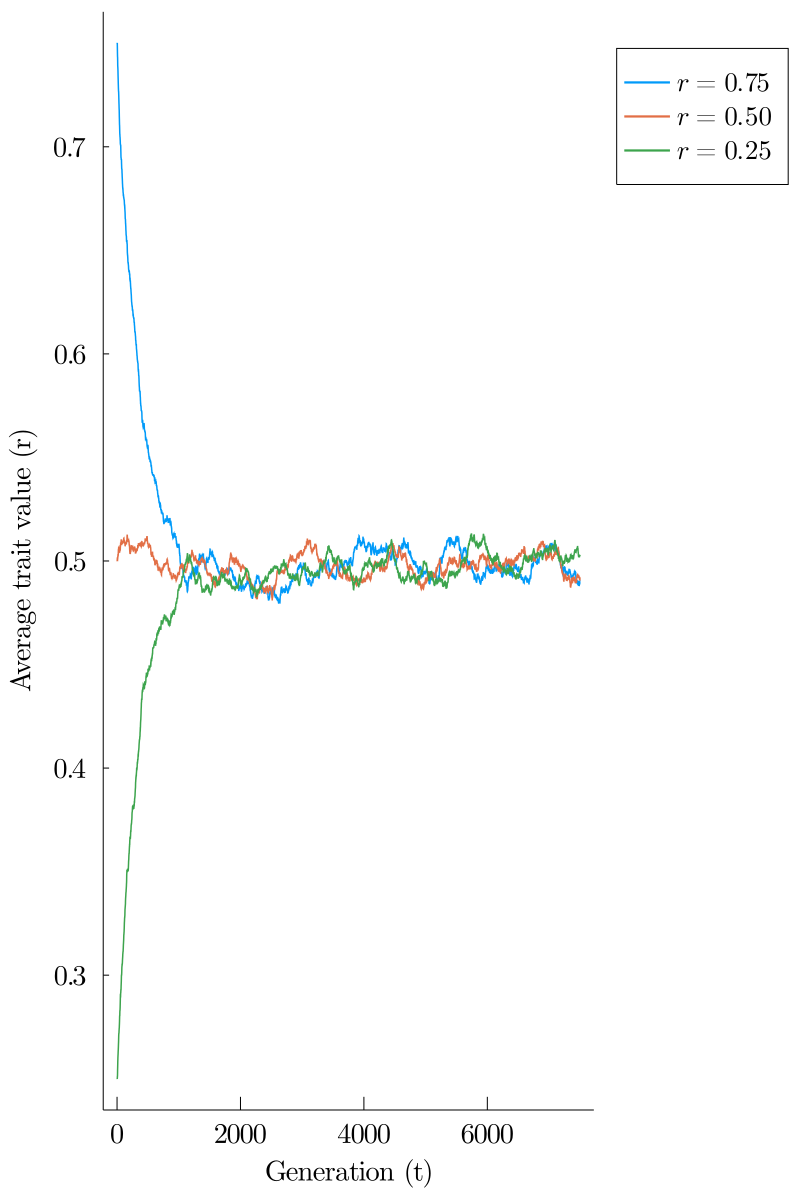

In [6]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.25",lw = 1.5)
plot!(size=(800,1200))
#savefig(plt1,"images\\file7.png")

In [46]:
x = collect(1:1:1500);
y = data[1][x];
z = data[2][x];
w = data[3][x];

┌ Info: Saved animation to 
│   fn = C:\Users\User\Hons Project\Julia ABM\tutorial_anim_fps30.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\SjqWU\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\Hons Project\\Julia ABM\\tutorial_anim_fps30.gif")
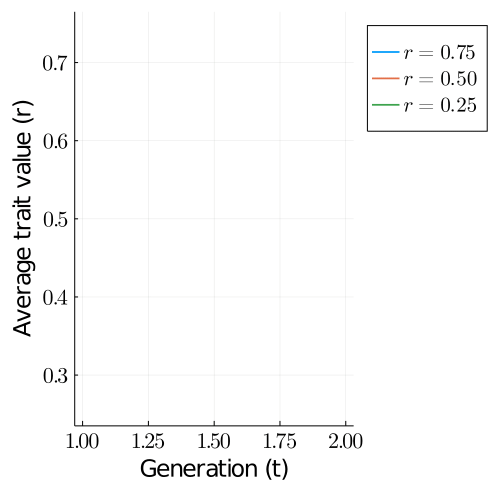

In [47]:
anim = @animate for i = 1:5:length(x)
    plot(x[1:i], y[1:i],
    labelfontsize = 16,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 14,
    tickfontfamily = "Computer Modern",
    tickfontsize = 14,
    size = (600, 600)
    )
    plot!(x[1:i],z[1:i],label = L"r = 0.50",lw = 1.5,size = (500, 500))
    plot!(x[1:i],w[1:i],label = L"r = 0.25",lw = 1.5,size = (500, 500))
end
 
gif(anim, "tutorial_anim_fps30.gif", fps = 60)

In [ ]:
using Plots
x = collect(1:0.1:30)
y = sin.(x)
df = 2
 
anim = @animate for i = 1:df:length(x)
    plot(x[1:i], y[1:i], legend=false)
end
 
gif(anim, "tutorial_anim_fps30.gif", fps = 30)

### Male Death Probability Higher
- Converge to FE

### Male Death Probability Higher & Longer Lifespan ##
- Converge to FE

### Female Death Probability Higher
- Converge to FE

### Female Death Probability & Longer Lifespan #
- Converge to FE

# <font color='red'>Haploid ABM </font> #

In [3]:
@everywhere mutable struct Haploid <: AbstractAgent
    id:: Int
    age:: Int
    max_age:: Int
    sex:: Int
    trait:: Float64
    island:: Int
end

@everywhere function model_step!(model)
    for i in allagents(model)
        i.age += 1
        if i.age > i.max_age
            kill_agent!(i,model)
        end
    end
    
    females = collect(filter!(x -> x.sex == 2 && x.age > 0, collect(allagents(model))));
    
    for i in females
       mates   = collect(filter!(x -> x.sex == 1 && x.age > 0 && x.island == i.island, collect(allagents(model))));
       if length(mates) > 0
           mate = rand(model.rng,mates)
           reproduce!(i,mate,model)
       end 
    end
    
    
    r = max(0,nagents(model)-limit);
    if r > 0
        x = StatsBase.sample(collect(allagents(model)),r; replace = false)
        for i in x
            kill_agent!(i,model)
        end
    end

end

@everywhere function agent_step!(agent::Haploid,model) end


@everywhere function reproduce!(agent,mate,model)
    
    child_s = (agent.trait + mate.trait)/2
    
    t1 = eps_m + mate.trait
    t2 = mate.trait - eps_m
    t3 = agent.trait + eps_m
    t4 = agent.trait - eps_m

    arr = [min(1,t1), max(t2,0),min(1,t3),max(0,t4)];
    arr2 = [agent.trait,mate.trait]
    
    
    for i = 1:c
        if nagents(model) > 2*limit
            return
        end
        
        if Int(rand(model.rng,Uniform(0,1)) < child_s) == 0
            if rand(model.rng,Uniform(0,1)) > death_rate[1]
                if rand(model.rng,Uniform(0,1)) > (1 - mutation_rate)
                    id = nextid(model)
                    offspring = Haploid(id,0,agent.max_age+k,2,rand(model.rng,arr),agent.island)
                    add_agent!(offspring, model)
                else
                    id = nextid(model)
                    offspring = Haploid(id,0,agent.max_age+k,2,rand(model.rng,arr2),agent.island)
                    add_agent!(offspring, model)
                end
            end
            
            
        else
            if rand(Uniform(0,1)) > death_rate[2]
                if rand(Uniform(0,1)) > (1 - mutation_rate)
                    id = nextid(model)
                    offspring = Haploid(id,0,agent.max_age+l,1,rand(model.rng,arr),agent.island)
                    add_agent!(offspring, model)
                else
                    id = nextid(model)
                    offspring = Haploid(id,0,agent.max_age+l,1,rand(model.rng,arr2),agent.island)
                    add_agent!(offspring, model)
                end
            end
        end
    end
        
end


@everywhere function init_m_haploid(
    n_agents,
    trait_value,
    age_limit,
    eps_m,
    c,
    mutation_rate,
    death_rate,
    k,
    l,
    limit,
    islands
)
    @everywhere model = ABM(Haploid,rng = Random.default_rng())
    id = 0
    is = 0
    for i = 1:n_agents
        id += 1
        
        if mod(i,2) == 0
            agent = Haploid(id,0,age_limit+k,2,trait_value,mod(is-1,islands))
            add_agent!(agent, model)
        else
            agent = Haploid(id,0,age_limit+l,1,trait_value,mod(is,islands))
            add_agent!(agent, model)
            is += 1
        
        end
    end
    return model
end

In [43]:
@everywhere num_agents = 250
@everywhere max_age = 1
@everywhere eps_m = 0.025
@everywhere c = 5
@everywhere mutation_rate =  1
@everywhere death_rate = [0.1,0.1]
@everywhere n_steps = 5000
@everywhere k = 0;
@everywhere l = 0;
@everywhere limit = 500;
@everywhere params = [0.25,0.5,0.75];

In [44]:
@everywhere adata = [:trait]
df = [DataFrame(),DataFrame(),DataFrame()]

for i = 3:-1:1 
    model = init_m_haploid(num_agents,params[i],max_age,eps_m,c,mutation_rate,death_rate,k,l,limit,1)

    data,_ = @time run!(model, agent_step!, model_step!,n_steps; adata=adata,
                   replicates=30,parallel = true)
    gd = groupby(data,[:step])
    data_mean = combine(gd,[:trait,:replicate] .=> mean)
    out = select(data_mean,Not(:replicate_mean));
    df[i] = out
end

 39.548743 seconds (47.91 k allocations: 4.813 GiB, 3.28% gc time)
 40.673247 seconds (47.12 k allocations: 4.813 GiB, 2.93% gc time)
 40.203321 seconds (47.16 k allocations: 4.813 GiB, 2.79% gc time)


In [45]:
temp_df = hcat(df[1],df[2],df[3],makeunique = true)
data = [temp_df[!,6],temp_df[!,4],temp_df[!,2]];
plt1 = plot(
    left_margin = 7.5mm,
    data[1],
    fontfamily = "Computer Modern", 
    labelfontsize = 18,
    xlabel = "Generation (t)",
    ylabel = "Average trait value (r)",
    labels =L"r = 0.75",
    lw = 1.5,
    legend= :outertopright,
    legendfontsize = 18,
    tickfontfamily = "Computer Modern",
    tickfontsize = 18,
    grid = false)
plot!(data[2],label = L"r = 0.50",lw = 1.5)
plot!(data[3],label = L"r = 0.25",lw = 1.5)
plot!(size=(800,1200))
savefig(plt1,"images\\file8.png")